# DIPA Project

In [ ]:
import os
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

# Check for GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class names (background + pothole)
CLASSES = ['__background__', 'pothole']
NUM_CLASSES = len(CLASSES)  # 2

### Pothole dataset class
- limit - number of images to load into dataset class
- .csv file structure - filename, width, height, class, xmin, ymin, xmax, ymax


In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, csv_file, image_dir, limit=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.image_files = self.df['filename'].unique()

        if limit is not None:
            self.image_files = self.image_files[:limit]  # limit number of images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image file
        image_id = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_id)
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img)

        # Get bounding box(es)
        records = self.df[self.df['filename'] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # All labels = 1 (pothole)
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            'iscrowd': torch.zeros((records.shape[0],), dtype=torch.int64)
        }

        return img_tensor, target

In [ ]:
def get_loaders(batch_size=4, train_limit=None):
    datasets = {
        'train': PotholeDataset("dataset/train/_annotations.csv", "dataset/train", limit=train_limit),
        'valid': PotholeDataset("dataset/valid/_annotations.csv", "dataset/valid", limit=train_limit),
        'test':  PotholeDataset("dataset/test/_annotations.csv", "dataset/test", limit=train_limit),
    }

    loaders = {
        split: DataLoader(datasets[split], batch_size=batch_size, shuffle=(split == 'train'),
                          collate_fn=lambda x: tuple(zip(*x)))
        for split in datasets
    } 
    return loaders

def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [7]:
def train(model, dataloader, optimizer, device, epochs=3):
    current_time = datetime.now().strftime("%H:%M:%S")
    print("Start Time:", current_time)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        current_time = datetime.now().strftime("%H:%M:%S")    
        print(f"Start Time Epoch({current_time+1}):")

        total_loss = 0.0
        for imgs, targets in dataloader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(imgs, targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")
        current_time = datetime.now().strftime("%H:%M:%S")    
        print(f"Finish Time Epoch({current_time+1}):")
    current_time = datetime.now().strftime("%H:%M:%S")
    print("Finish Time:", current_time)

def visualize(model, dataloader, device, num_images=20, score_threshold=0.8):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = list(img.to(device) for img in imgs)
            outputs = model(imgs)

            for i, output in enumerate(outputs):
                img_np = imgs[i].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img_np)

                # Draw only boxes with high confidence
                for box, score in zip(output['boxes'], output['scores']):
                    if score >= score_threshold:
                        x1, y1, x2, y2 = box.int()
                        plt.gca().add_patch(plt.Rectangle(
                            (x1, y1), x2 - x1, y2 - y1,
                            edgecolor='red', fill=False, linewidth=1
                        ))
                        plt.text(x1, y1 - 5, f"{score:.2f}", color="red", fontsize=8)

                plt.title("Predicted Bounding Boxes")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return 


In [5]:
if __name__ == '__main__':
    # Load data
    loaders = get_loaders(batch_size=4, train_limit=500)

    # ---- MODEL 1: Faster R-CNN ----
    print("\n--- Training Faster R-CNN ---")
    fasterrcnn = get_fasterrcnn_model(NUM_CLASSES)
    optimizer1 = torch.optim.SGD(fasterrcnn.parameters(), lr=0.005, momentum=0.9)
    current_time = datetime.now().strftime("%H:%M:%S")
    print("Start Time:", current_time)
    train(fasterrcnn, loaders['train'], optimizer1, DEVICE, epochs=3)
    current_time = datetime.now().strftime("%H:%M:%S")
    print("Finish Time:", current_time)




--- Training Faster R-CNN ---


c:\Users\joze\Desktop\DIPA_Project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\joze\Desktop\DIPA_Project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 53.5349
[Epoch 2] Loss: 38.0087
[Epoch 3] Loss: 33.5838



--- Validating Faster R-CNN ---


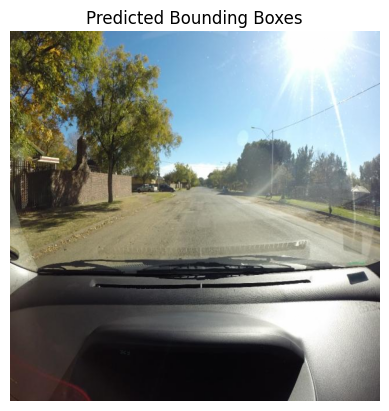

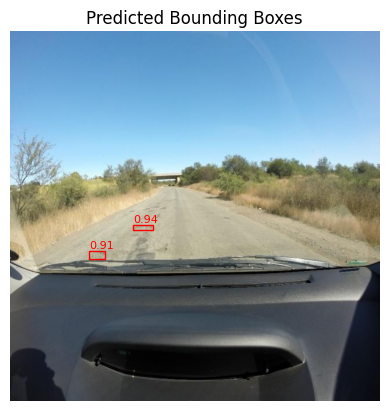

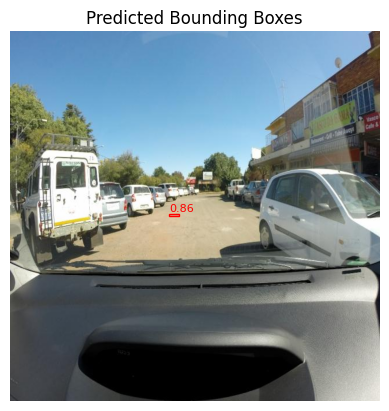

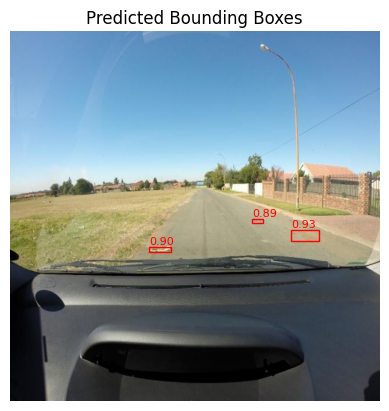

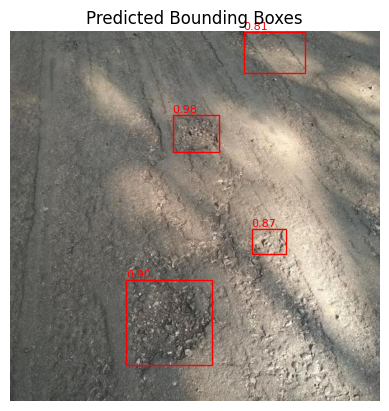

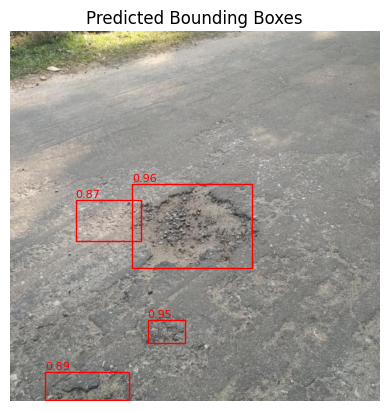

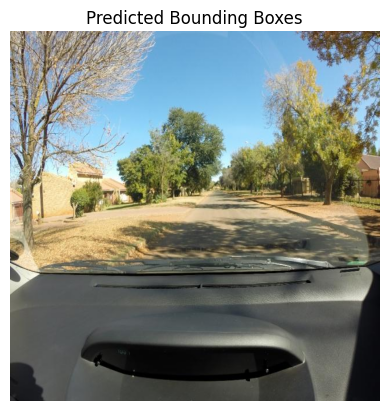

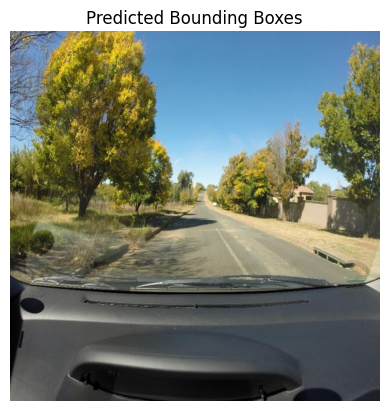

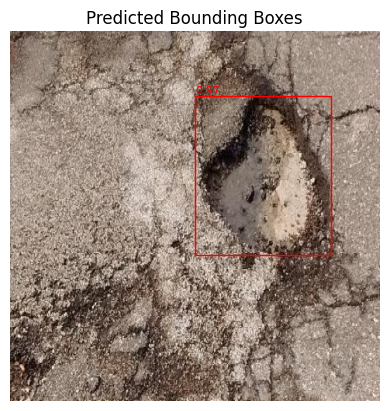

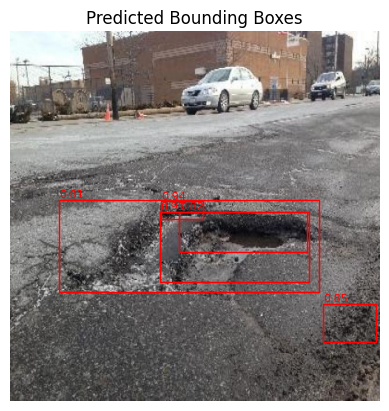

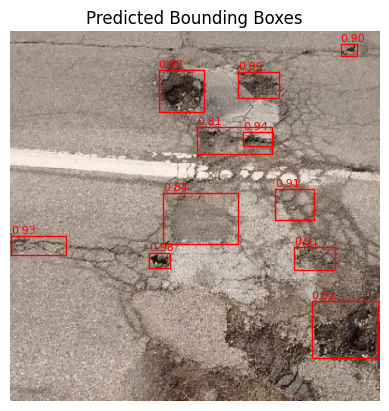

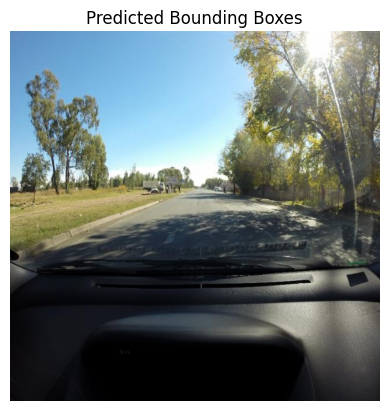

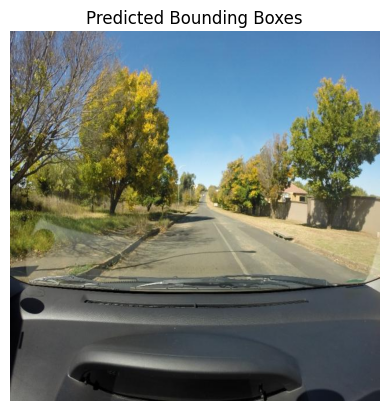

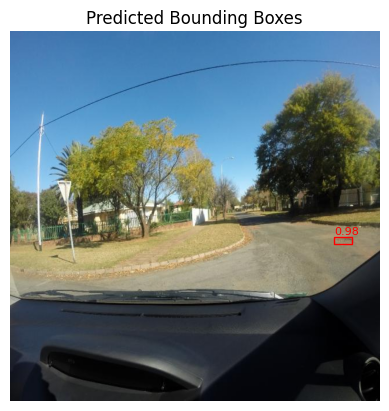

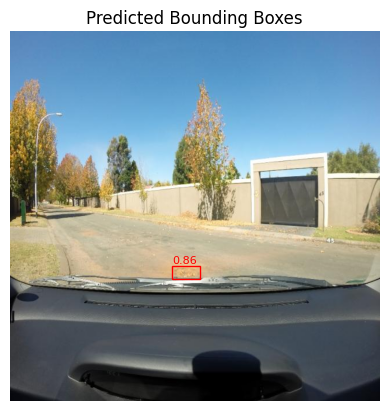

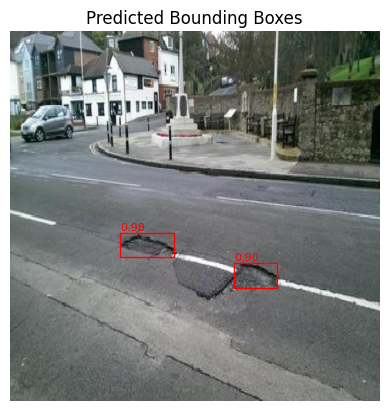

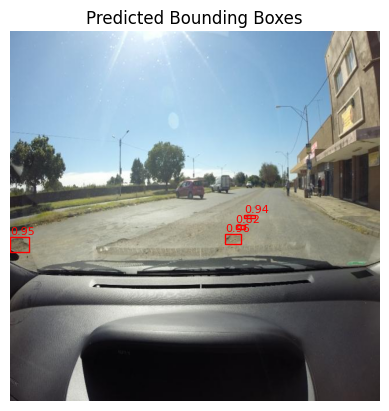

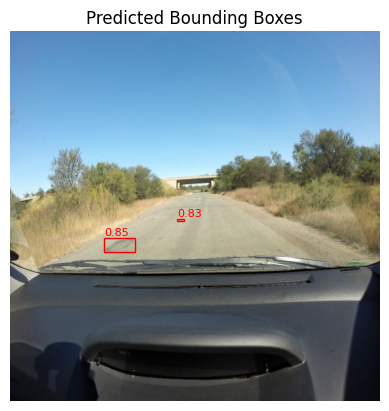

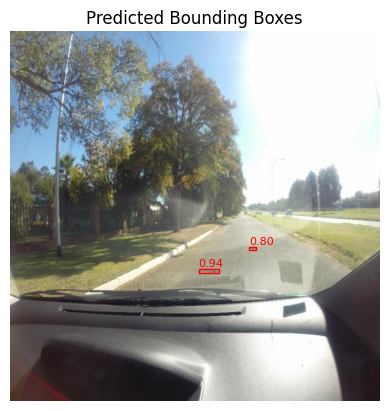

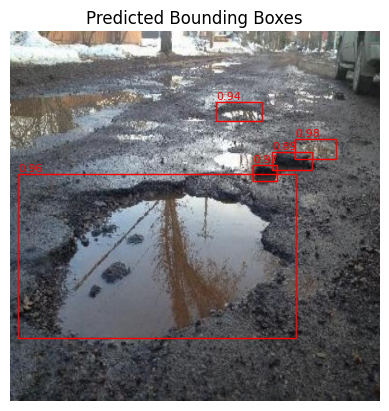

In [8]:
print("\n--- Validating Faster R-CNN ---")
visualize(fasterrcnn, loaders['valid'], DEVICE)